In [73]:
import os
import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout
    from tensorflow.keras.optimizers import Adam, RMSprop
from pandas import read_csv, DataFrame, concat
from datetime import datetime, timedelta
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import numpy as np 
import pandas as pd 
from keras.utils import plot_model
import pickle
import math

months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 
          'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,
         'November': 11, 'December': 12}

def encode(l):
    encoded = []
    for m in l:
        for key, value in months.items():
            if key == m:
                encoded.append(value)
    return encoded


def parse(x):
    return datetime.strptime(x, '%m/%d/%Y')

forecast_length = 200 
seed = 0
name = 'prices_july_' + str(seed)
tf.set_random_seed(seed)
shift = 8
# Extend calendar to fit forecast_length
add_weeks = math.ceil((forecast_length+shift)/5)

# Data Loading
data_set = pd.read_csv('july2020clean.csv', sep =',', date_parser = parse)
data_set = data_set.iloc[:data_set['totalSoybeanMealSupply'].last_valid_index(),:] # Truncate dataset to those where every data is available 
'''
'closePrice','openPrice','highPrice','lowPrice','totalSoybeanMealSupply','totalSoybeanMealDemand','soybeanOilSupply','soybeanOilDemand','sunflowerSeedPrice','canolaPrice','peanutsPrice','flaxseedPrice','soybeanOilPrice','cottonseedOilPrice','sunflowerseedOilPrice','canolaOilPrice','peanutOilPrice','cornOilPrice','soybeanMealPrice','cottonseedmealPrice','sunflowerseedMealPrice','linseedMealPrice'
'canolaOilPrice', 'soybeanOilPrice', 'soybeanMealPrice', 'cottonseedmealPrice', 'sunflowerseedMealPrice'
'totalSoybeanMealSupply','totalSoybeanMealDemand'
'''
target_cols = ['closePrice','canolaOilPrice', 'soybeanOilPrice', 'soybeanMealPrice', 'cottonseedmealPrice', 'sunflowerseedMealPrice', 'Month']
data_set['Month'] = encode(data_set['Month'])
dates = data_set['date'].tolist()
data_set = data_set.loc[:,target_cols]


for i in range(len(dates)):
    dates[i] = parse(dates[i])
    
last_week = dates[-5:]

for i in range(add_weeks):
    dates += [x + timedelta(days = 7) for x in last_week]
    last_week = dates[-5:]



In [74]:
values = data_set.values
values = values.astype('float32')
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

scaler2 = MinMaxScaler()
transformed_dates = scaler2.fit_transform(np.asarray([x.month for x in dates]).reshape(len(dates),-1))

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [75]:
def series_to_supervised(data, seq_length, y_col):
    X = [] 
    Y = []
    for time in range(len(data)-seq_length):
        X += [data[time:time+seq_length]]
        Y += [data[time+seq_length][y_col]]
    
    return X,Y


data_x, data_y = scaled[:-shift], scaled[shift:]
separation = int(len(data_x)*0.8)
train_x, train_y = data_x[:separation], data_y[:separation]
test_x, test_y = data_x[separation:], data_y[separation:]
train_x = train_x.reshape(1, train_x.shape[0], train_x.shape[1])
train_y = train_y.reshape(1, train_y.shape[0], train_y.shape[1])
test_x = test_x.reshape(1, test_x.shape[0], test_x.shape[1])
test_y = test_y.reshape(1, test_y.shape[0], test_y.shape[1])
data_x = data_x.reshape(1, data_x.shape[0], data_x.shape[1])
data_y = data_y.reshape(1, data_y.shape[0], data_y.shape[1])
print(train_x.shape)
print(train_y.shape)

(1, 319, 7)
(1, 319, 7)


Fitting model...


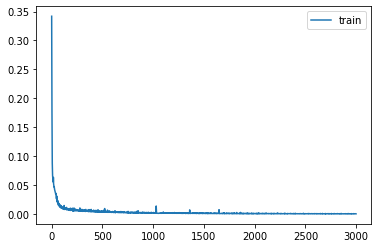

In [76]:
# design network
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """
    warmup_steps = 50
    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, stateful = False, input_shape = (None, train_x.shape[2])))
regressor.add(LSTM(units = train_x.shape[2], return_sequences = True, stateful = False))
regressor.compile(optimizer = RMSprop(lr=1e-3), loss = loss_mse_warmup)

print('Fitting model...')
history = regressor.fit(train_x, train_y, epochs = 3000, verbose=0)

# plot history
pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# print(model.get_weights())

In [77]:
newModel = Sequential()
newModel.add(LSTM(units = 50, return_sequences = True, stateful = True, batch_input_shape = (1, None, train_x.shape[2])))
newModel.add(LSTM(units = train_x.shape[2], return_sequences = False, stateful = True))

newModel.set_weights(regressor.get_weights())

forecastFromSelf = np.empty((1, train_x.shape[1] + forecast_length, train_x.shape[2]))
forecastData = np.empty((1, train_x.shape[1] + forecast_length, train_x.shape[2]))
forecastData[:,:train_x.shape[1], :] = train_x[:,:,:]


for i in range(train_x.shape[1]+forecast_length):
    input_data = forecastData[:,i:i+1,:]
    forecastFromSelf[:,i:i+1,:] = newModel.predict(forecastData[:,i:i+1,:])
    forecastFromSelf[:,i,-1] = transformed_dates[i+shift,0] # Replace prediction with what's already known
    output_data = forecastFromSelf[:,i:i+1,:]
    if i + shift >= train_x.shape[1] and i + shift < forecastData.shape[1]:
        forecastData[:,i+shift:i+shift+1,:] = forecastFromSelf[:,i:i+1,:]

y_hat = scaler.inverse_transform(forecastFromSelf.reshape((forecastFromSelf.shape[1],forecastFromSelf.shape[2])))


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


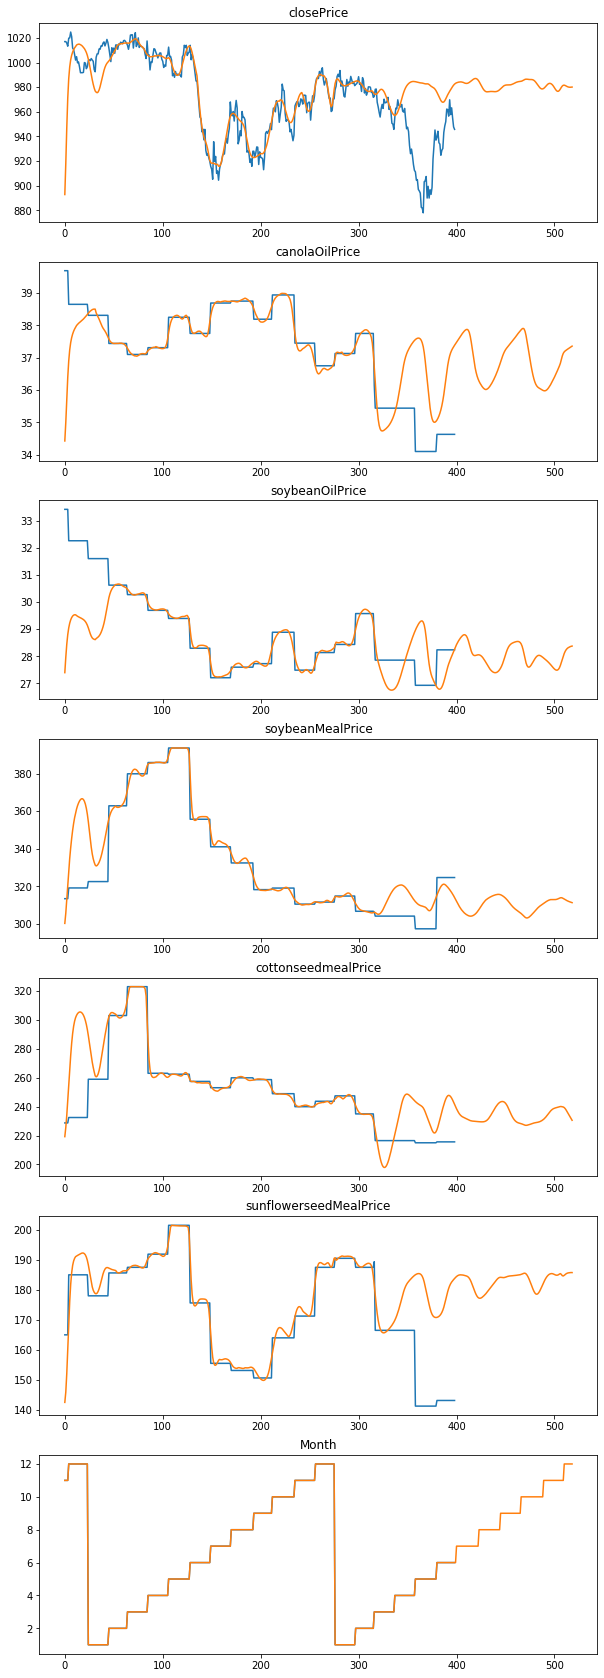

In [78]:
a = pyplot.figure()
a.set_size_inches(10,30)
for i in range(y_hat.shape[1]):
    ax = a.add_subplot(y_hat.shape[1],1,i+1)
    b = data_y
    b = b.reshape(b.shape[1], b.shape[2])
    b = scaler.inverse_transform(b)
    ax.plot(b[:,i])
    ax.plot(y_hat[:,i])
    ax.title.set_text(target_cols[i])
a.savefig(fname='./data/{}.png'.format(name))
a.show()

In [79]:
# Export data 
regressor.save(open('pickles/{}.p'.format(name), 'wb'))

    
dates = dates[shift:y_hat.shape[0]+shift]
output_dict = {'Date':dates}
for i, col in enumerate(target_cols):
    output_dict[col] = y_hat[:,i]


output_df = DataFrame(output_dict, columns=['Date']+target_cols)
output_df.to_csv('./data/{}.csv'.format(name))